# A Closed Form Reduced Order Electrochemical Model for Lithium-Ion Cells

## Introduction

This model considers a Li-ion cell connected to an external load in a circuit. We consider that that a 3-dimensional cylindrical cell can be opened up as a sheet of paper of negligible thickness, now also assume that no change in any physical quantity occurs along the width. This turn our 3D system to a 1D one. 

Now according to standard conventions let's assume that our cell consists of **3 regions**, the **-ve electrode**, **the separator** and the **+ve electrode**. Also assume that the cell has collectors at end of either electrode. We'll be having the standard reactions in the +ve and -ve electrodes as below:

*-ve electrode:*

<div align=center>LiC₆ → x.Li⁺ + Li₁₋ₓC₆ + x.e⁻</div>

*+ve electrode:*

<div align=center>x.Li⁺ + LiMO₂ + x.e⁻ → Li₁₊ₓMO₂</div>


With this our system should look like below.

<div align=center><img src="../assets/senthil/li_cell.png"></div>

Assume that we have `x = 0` at the -ve electrode and `x = L` at the +ve electrode, L being the cell length. Length of the regions from left to right being lₙ, lₛ and lₚ respectively.

## The difference
This model build upon the SenthilModel where the reaction rate was assumed constant. However, that assumption is not accurate as cell reaction rate changes with time, to accomodate for the above condition, it is assusmed that the cell reaction rate follows an exponentially decreasing profile. This model is also called the Non uniform reduced order model, henceforth **NUROM**.


## Importing necessary libraries
To get started import the CaseStudy's senthil model (as sm for convinence) as that's the model which we're simulating. Also import Gadfly as that's the plotting library we're gonna use. To see the model constants [check here.](../src/ashwini/constants/constants.jl)

In [80]:
import LiionBatteryModels.AshwiniModel as am 
using Gadfly

set_default_plot_size(800px, 600px)

## Cell Voltage for constant current
In this example we'll be showing the cases of *constant current*. The example describes all the internal model variables also.

We start with a current of 1C or 13.5mA over a time range of 25000s with intervals of 10s.

In [81]:
I = 11.5/0.4275
t = Float64.(0:10:3490)
tspan = 10

println("Discharge current: ", I)

Discharge current: 26.900584795321638


We start with calculating the initial model parameters dₙ₁ and dₚ₁.

In [82]:
dₚ₁ = am.dₚ₁₀(I)
dₙ₁ = am.dₙ₁₀(I)

println("dₚ₁= ", dₚ₁,", dₙ₁ = ", dₙ₁)

dₚ₁= 0.12124039904283809, dₙ₁ = 0.12131881284718728


We calculate the secondary model parameters dₙ₂ and dₚ₂.

In [83]:
dₚ₂ = am.dₚ₂(dₚ₁)
dₙ₂ = am.dₙ₂(dₙ₁)

println("dₚ₂= ", dₚ₂,", dₙ₂ = ", dₙ₂)

dₚ₂= 1.9799978061924177, dₙ₂ = 1.979985002116882


Let's create arrays to store the time series of internal variables that will be calculated along the way

In [84]:
# Stores for required time series of variables

# Reaction rate @x = 0 & x = lₙ, lₙ + lₛ & x = L
jₙ₀  = zeros(size(t)[1])
jₙₗ  = zeros(size(t)[1])

jₚ₀ = zeros(size(t)[1]);
jₚₗ = zeros(size(t)[1]);


# Average concentrations in different regions.
c₂̄ₙ = zeros(size(t)[1])
c₂̄ₚ = zeros(size(t)[1])
c₂̄ₛ = zeros(size(t)[1])

# Electrolyte concentration @x = 0 & x = lₙ, lₙ + lₛ & x = L
c₂ₙ₀ = zeros(size(t)[1])
c₂ₙₗ = zeros(size(t)[1]) # c₂ᵢₙ

c₂ₘ = zeros(size(t)[1])

c₂ₚ₀ = zeros(size(t)[1]) # c₂ᵢₚ
c₂ₚₗ = zeros(size(t)[1]) 


# Solid concentration @x = 0, lₙ, lₙ + lₛ, L
c₁ₙ₀ = zeros(size(t)[1])
c₁ₙₗ = zeros(size(t)[1])

c₁ₚ₀ = zeros(size(t)[1])
c₁ₚₗ = zeros(size(t)[1])

# Radial gradient of Solid concentration @x = 0, lₙ, lₙ + lₛ, L
c₁ₙᵣ₀ = zeros(size(t)[1])
c₁ₙᵣₗ = zeros(size(t)[1])

c₁ₚᵣ₀ = zeros(size(t)[1])
c₁ₚᵣₗ = zeros(size(t)[1])

# Surface solid concentration @x = 0, lₙ, lₙ + lₛ, L
cₛₙ₀ = zeros(size(t)[1])
cₛₙₗ = zeros(size(t)[1])

cₛₚ₀ = zeros(size(t)[1])
cₛₚₗ = zeros(size(t)[1])

# Electrolyte potential @x= 0, lₙ, lₙ + lₛ, L
ϕ₂ₙ₀ = zeros(size(t)[1])
ϕ₂ₙₗ = zeros(size(t)[1]) # ϕ₂ᵢₙ

ϕ₂ₚ₀ = zeros(size(t)[1]) # ϕ₂ᵢₚ
ϕ₂ₚₗ = zeros(size(t)[1])


# Solid potential @x = 0, lₙ, lₙ + lₛ, L
ϕ₁ₙ₀ = zeros(size(t)[1])
ϕ₁ₙₗ = zeros(size(t)[1])

ϕ₁ₚ₀ = zeros(size(t)[1])
ϕ₁ₚₗ = zeros(size(t)[1])

# Voltage accross the cell terminals
V = zeros(size(t)[1]);

### Initial value storing.
Lets store all the initial values of the time series we mentioned above.

In [85]:
println("Initial values of the variables:\n")

# Reaction rate @x = 0 & x = lₙ, lₙ + lₛ & x = L

jₙ₀[1] = am.jₙ(0, dₙ₁, dₙ₂, I)
jₙₗ[1] = am.jₙ(am.lₙ, dₙ₁, dₙ₂, I)

jₚ₀[1] = am.jₚ(am.L - am.lₚ, dₚ₁, dₚ₂, I)
jₚₗ[1] = am.jₚ(am.L, dₚ₁, dₚ₂, I)

println("Reaction rates jₙ₀ = ", jₙ₀[1], ", jₚₗ = ", jₚₗ[1])

# Average electrolyte concentration in the anode, separator and cathode

c₂̄ₙ[1] = am.c₂₀
c₂̄ₛ[1] = am.c₂₀
c₂̄ₚ[1] = am.c₂₀

# Electrolyte concentration @x = 0 & x = lₙ, lₙ + lₛ & x = L

c₂ₙ₀[1] = am.c₂₀
c₂ₙₗ[1] = am.c₂₀

c₂ₘ[1] = am.c₂₀

c₂ₚ₀[1] = am.c₂₀
c₂ₚₗ[1] = am.c₂₀

# Electrolyte potential @x= 0, lₙ, lₙ + lₛ, L
ϕ₂ₙₗ[1] = am.ϕ₂ᵢₙ(I, c₂ₙₗ[1], c₂ₘ[1]) # ϕ₂ᵢₙ
ϕ₂ₙ₀[1] = am.ϕ₂ₙ(0, I, c₂ₙ₀[1], c₂ₘ[1], ϕ₂ₙₗ[1], dₙ₁)

ϕ₂ₚₗ[1] = am.ϕ₂ᵢₚ(I, c₂ₚ₀[1], c₂ₘ[1])
ϕ₂ₚ₀[1] =  am.ϕ₂ₚ(am.L, I, c₂ₚₗ[1], c₂ₘ[1], ϕ₂ₚₗ[1], dₚ₁)  # ϕ₂ᵢₚ

println("Electrolyte potentials ϕ₂ₙ₀ = ", ϕ₂ₙ₀[1], ", ϕ₂ₚₗ = ", ϕ₂ₚₗ[1])

# Solid concentration @x = 0, lₙ, lₙ + lₛ, L

c₁ₙ₀[1] = am.c₁ₙ₀
c₁ₙₗ[1] = am.c₁ₙ₀

c₁ₚ₀[1] = am.c₁ₚ₀
c₁ₚₗ[1] = am.c₁ₚ₀

println("Solid concentrations c₁ₙ₀ = ", c₁ₙ₀[1], ", c₁ₚₗ = ", c₁ₚₗ[1])

# Radial gradient of Solid concentration @x = 0, lₙ, lₙ + lₛ, L
c₁ₙᵣ₀[1] = 0
c₁ₙᵣₗ[1] = 0

c₁ₚᵣ₀[1] = 0
c₁ₚᵣₗ[1] = 0

# Surface solid concentration @x = 0, lₙ, lₙ + lₛ, L
cₛₙ₀[1] = am.cₛₙ(jₙ₀[1], c₁ₙ₀[1], c₁ₙᵣ₀[1])
cₛₙₗ[1] = am.cₛₙ(jₙₗ[1], c₁ₙₗ[1], c₁ₙᵣₗ[1])

cₛₚ₀[1] = am.cₛₚ(jₚ₀[1], c₁ₚ₀[1], c₁ₚᵣ₀[1])
cₛₚₗ[1] = am.cₛₚ(jₚₗ[1], c₁ₚₗ[1], c₁ₚᵣₗ[1])

println("Surface solid concentrations cₛₙ₀ = ", cₛₙ₀[1], ", cₛₚₗ = ", cₛₚₗ[1])

# Solid potential @x = 0, lₙ, lₙ + lₛ, L
ϕ₁ₙ₀[1] = am.ϕ₁ₙ(jₙ₀[1], cₛₙ₀[1], c₂ₙ₀[1], ϕ₂ₙ₀[1])
ϕ₁ₙₗ[1] = am.ϕ₁ₙ(jₙₗ[1], cₛₙₗ[1], c₂ₙₗ[1], ϕ₂ₙₗ[1])

ϕ₁ₚ₀[1] = am.ϕ₁ₚ(jₚ₀[1], cₛₚ₀[1], c₂ₚ₀[1], ϕ₂ₚ₀[1])
ϕ₁ₚₗ[1] = am.ϕ₁ₚ(jₚₗ[1], cₛₚₗ[1], c₂ₚₗ[1], ϕ₂ₚₗ[1])

println("Solid potentials ϕ₁ₙ₀ = ", ϕ₁ₙ₀[1], ", ϕ₁ₚₗ = ", ϕ₁ₚₗ[1])

# Calculating the voltage
V[1] = ϕ₁ₚₗ[1] - ϕ₁ₙ₀[1]

println("Voltage V = ", V[1]);

# Updating model parameters
dₙ₁ = am.dₙ₁(I, cₛₙ₀[1], cₛₙₗ[1], c₂ₙₗ[1], c₂ₙ₀[1], c₂̄ₙ[1])
dₚ₁ = am.dₚ₁(I, cₛₚ₀[1], cₛₚₗ[1], c₂ₚₗ[1], c₂ₚ₀[1], c₂̄ₚ[1])

dₚ₂ = am.dₚ₂(dₚ₁);
dₙ₂ = am.dₙ₂(dₙ₁);

Initial values of the variables:

Reaction rates jₙ₀ = 1.8210424818208504e-5, jₚₗ = -1.010904832655539e-5
Electrolyte potentials ϕ₂ₙ₀ = 0.009647196644349407, ϕ₂ₚₗ = -0.0034980184823711034
Solid concentrations c₁ₙ₀ = 19528.6, c₁ₚₗ = 8000.999999999999
Surface solid concentrations cₛₙ₀ = 19361.83786796512, cₛₚₗ = 8033.690473949294
Solid potentials ϕ₁ₙ₀ = 0.08138264859359627, ϕ₁ₚₗ = 4.28079166808689
Voltage V = 4.199409019493293


### Model solving
We start with calculation of solid concentration field and then calculate the electrolyte concentration field. From this we calculate electrolyte potential field. Now from this we calculate the solid potential field, from which we can Finally calculate the cell voltage.

Note that all of this iteratively moving from t=0 to t=25000s in time deltas of 10s.

In [86]:
for i = 2:size(t)[1]
    jₙ₀[i] = am.jₙ(0, dₙ₁, dₙ₂, I)
    jₙₗ[i] = am.jₙ(am.lₙ, dₙ₁, dₙ₂, I)

    jₚ₀[i] = am.jₚ(am.lₙ + am.lₛ, dₚ₁, dₚ₂, I)
    jₚₗ[i] = am.jₚ(am.L, dₚ₁, dₚ₂, I)

    # Calculation of solid concentration field.
    c₁ₙ₀[i] = am.c₁ₙ(tspan, jₙ₀[i], c₁ₙ₀[i-1])
    c₁ₙₗ[i] = am.c₁ₙ(tspan, jₙₗ[i], c₁ₙₗ[i-1])

    c₁ₚ₀[i] = am.c₁ₚ(tspan, jₚ₀[i], c₁ₚ₀[i-1])
    c₁ₚₗ[i] = am.c₁ₚ(tspan, jₚₗ[i], c₁ₚₗ[i-1])

    # Calculation of Radial gradient of Solid concentration field.
    c₁ₙᵣ₀[i] = am.c₁ₙᵣ(tspan, jₙ₀[i], c₁ₙᵣ₀[i-1])
    c₁ₙᵣₗ[i] = am.c₁ₙᵣ(tspan, jₙₗ[i], c₁ₙᵣₗ[i-1])

    c₁ₚᵣ₀[i] = am.c₁ₚᵣ(tspan, jₚ₀[i], c₁ₚᵣ₀[i-1])
    c₁ₚᵣₗ[i] = am.c₁ₚᵣ(tspan, jₚₗ[i], c₁ₚᵣₗ[i-1])

    # Calculation of solid surface concentration field.
    cₛₙ₀[i] = am.cₛₙ(jₙ₀[i], c₁ₙ₀[i], c₁ₙᵣ₀[i])
    cₛₙₗ[i] = am.cₛₙ(jₙₗ[i], c₁ₙₗ[i], c₁ₙᵣₗ[i])

    cₛₚ₀[i] = am.cₛₚ(jₚ₀[i], c₁ₚ₀[i], c₁ₚᵣ₀[i])
    cₛₚₗ[i] = am.cₛₚ(jₚₗ[i], c₁ₚₗ[i], c₁ₚᵣₗ[i])

    # Calculation of electrolyte concentration field
    params = am.param_solver(
        I, tspan, 
        c₂̄ₙ[i-1], c₂̄ₚ[i-1], c₂̄ₛ[i-1], 
        c₂ₙ₀[i-1], c₂ₚₗ[i-1], 
        jₙ₀[i], jₚₗ[i]
    )

    n0 = params[1]; n1 = params[2]; n2 = params[3]; n3 = params[4];
    p0 = params[5]; p1 = params[6]; p2 = params[7]; p3 = params[8];
    s0 = params[9]; s1 = params[10]; s2 = params[11];

    c₂̄ₙ[i] = params[12];
    c₂̄ₚ[i] = params[13];
    c₂̄ₛ[i] = params[14];
    c₂ₙ₀[i] = params[15];
    c₂ₚₗ[i] = params[16];

    paramsₙ = [n0, n2, n3];
    paramsₛ = [s0, s1, s2];
    paramsₚ = [p0, p2, p3];

    c₂ₙₗ[i] = am.c₂(am.lₙ, paramsₙ);
    c₂ₚ₀[i] = am.c₂(am.lₙ + am.lₛ, paramsₛ);

    ϕ₂ₙ₀[i] = am.ϕ₂(0, I, paramsₙ, paramsₛ, dₙ₁)
    ϕ₂ₙₗ[i] = am.ϕ₂(am.lₙ, I, paramsₙ, paramsₛ, dₙ₁)
    ϕ₂ₚ₀[i] = am.ϕ₂(am.L - am.lₚ, I, paramsₚ, paramsₛ, dₙ₁)
    ϕ₂ₚₗ[i] = am.ϕ₂(am.L, I, paramsₚ, paramsₛ, dₙ₁)

    ϕ₁ₙ₀[i] = am.ϕ₁(0, I, cₛₙ₀[i], paramsₙ,paramsₛ, dₙ₁)
    ϕ₁ₙₗ[i] = am.ϕ₁(am.lₙ, I, cₛₙₗ[i], paramsₙ, paramsₛ, dₙ₁)
    ϕ₁ₚ₀[i] = am.ϕ₁(am.L - am.lₚ, I, cₛₚ₀[i], paramsₚ, paramsₛ, dₚ₁)
    ϕ₁ₚₗ[i] = am.ϕ₁(am.L, I, cₛₚₗ[i], paramsₚ, paramsₛ, dₚ₁)

    V[i] = ϕ₁ₚₗ[i] - ϕ₁ₙ₀[i]
    
    dₙ₁ = am.dₙ₁(I, cₛₙ₀[i], cₛₙₗ[i], paramsₙ)
    dₚ₁ = am.dₙ₁(I,  cₛₚ₀[i], cₛₚₗ[i], paramsₚ)

    dₚ₂ = am.dₚ₂(dₚ₁)
    dₙ₂ = am.dₙ₂(dₙ₁)
end

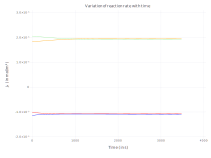

In [87]:
plot(
    layer(x=t[1:349], y=jₙ₀[1:349], Geom.line, color=[colorant"orange"]),
    layer(x=t[1:349], y=jₙₗ[1:349], Geom.line, color=[colorant"lightgreen"]),
    layer(x=t[1:349], y=jₚ₀[1:349], Geom.line, color=[colorant"blue"]),
    layer(x=t[1:349], y=jₚₗ[1:349], Geom.line, color=[colorant"red"]),
    Guide.title("Variation of reaction rate with time"),
    Guide.xlabel("Time (in s)"),
    Guide.ylabel("jₖ (in mol/m³)"),
)

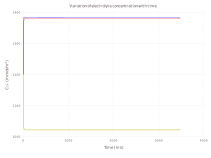

In [88]:
plot(
    layer(x=t[1:349], y=c₂ₙ₀[1:349], Geom.line, color=[colorant"orange"]),
    layer(x=t[1:349], y=c₂ₙₗ[1:349], Geom.line, color=[colorant"lightgreen"]),
    layer(x=t[1:349], y=c₂ₚ₀[1:349], Geom.line, color=[colorant"blue"]),
    layer(x=t[1:349], y=c₂ₚₗ[1:349], Geom.line, color=[colorant"red"]),
    Guide.title("Variation of electrolyte concentration with time"),
    Guide.xlabel("Time (in s)"),
    Guide.ylabel("C₂ₖ (in mol/m³)"),
)

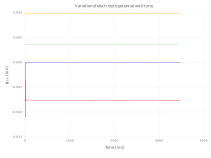

In [89]:
plot(
    layer(x=t[1:349], y=ϕ₂ₙ₀[1:349], Geom.line, color=[colorant"orange"]),
    layer(x=t[1:349], y=ϕ₂ₙₗ[1:349], Geom.line, color=[colorant"lightgreen"]),
    layer(x=t[1:349], y=ϕ₂ₚ₀[1:349], Geom.line, color=[colorant"blue"]),
    layer(x=t[1:349], y=ϕ₂ₚₗ[1:349], Geom.line, color=[colorant"red"]),
    Guide.title("Variation of electrolyte potential with time"),
    Guide.xlabel("Time (in s)"),
    Guide.ylabel("ϕ₂ₖ (in V)"),
)

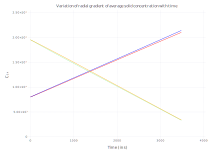

In [90]:
plot(
    layer(x=t[1:349], y=c₁ₙ₀[1:349], Geom.line, color=[colorant"orange"]),
    layer(x=t[1:349], y=c₁ₙₗ[1:349], Geom.line, color=[colorant"lightgreen"]),
    layer(x=t[1:349], y=c₁ₚ₀[1:349], Geom.line, color=[colorant"blue"]),
    layer(x=t[1:349], y=c₁ₚₗ[1:349], Geom.line, color=[colorant"red"]),
    Guide.title("Variation of radial gradient of average solid concentration with time"),
    Guide.xlabel("Time (in s)"),
    Guide.ylabel("C₁ₖ"),
)

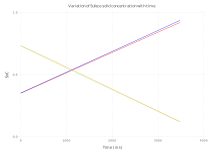

In [91]:
xp0 = cₛₚ₀/am.c₁ₚₘₐₓ
xpl = cₛₚₗ/am.c₁ₚₘₐₓ
yp0 = cₛₙ₀/am.c₁ₙₘₐₓ
ypl = cₛₙₗ/am.c₁ₙₘₐₓ


plot(
    layer(x=t[1:349], y=yp0[1:349], Geom.line, color=[colorant"orange"]),
    layer(x=t[1:349], y=ypl[1:349], Geom.line, color=[colorant"lightgreen"]),
    layer(x=t[1:349], y=xp0[1:349], Geom.line, color=[colorant"blue"]),
    layer(x=t[1:349], y=xpl[1:349], Geom.line, color=[colorant"red"]),
    Guide.title("Variation of Suface solid concentration with time"),
    Guide.xlabel("Time (in s)"),
    Guide.ylabel("SoC"),
)

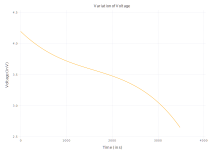

In [92]:

plot(
    layer(x=t[1:349], y=V[1:349], Geom.line, color=[colorant"orange"]),
    Guide.title("Variation of Voltage"),
    Guide.xlabel("Time (in s)"),
    Guide.ylabel("Voltage (in V)"),
)


[4.325112500000001, 4.2860128, 4.2493539, 4.215053600000001, 4.1830297000000005, 4.153200000000001, 4.125482300000002, 4.099794400000001, 4.0760541, 4.0541792, 4.0340875, 4.015696800000001, 3.9989249000000013, 3.983689600000001, 3.969908700000001, 3.957500000000001, 3.9463813000000014, 3.936470400000001, 3.9276851, 3.9199432, 3.9131624999999994, 3.9072608000000004, 3.9021559000000026, 3.8977656000000014, 3.894007700000002, 3.890800000000001, 3.888060300000001, 3.885706400000001, 3.883656100000001, 3.881827200000001, 3.8801375000000005, 3.8785048000000004, 3.876846900000001, 3.875081599999999, 3.8731267000000003, 3.8709000000000016, 3.868319300000003, 3.8653024000000027, 3.861767099999999, 3.857631200000003, 3.8528125000000006, 3.8472288000000026, 3.8407978999999983, 3.8334376000000008, 3.8250657000000015, 3.8156000000000043, 3.804958300000001, 3.7930584000000023, 3.7798181, 3.7651552000000024, 3.7489875, 3.731232800000001, 3.7118088999999994, 3.6906336000000017, 3.667624700000001, 3.64

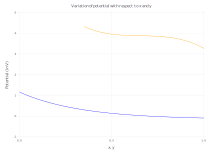

In [93]:
xi = 0.35: 0.01: 1
yi = 0: 0.01: 1

Up= zeros(size(xi)[1])
Un = zeros(size(yi)[1])

for i = 1:size(xi)[1]
    Up[i] = am.Uₚ(xi[i]*am.c₁ₚₘₐₓ)
end

for i = 1:size(yi)[1]
    Un[i] = am.Uₙ(yi[i]*am.c₁ₙₘₐₓ)
end

println(Up)
println(Un)

plot(
    layer(x=xi, y=Up, Geom.line, color=[colorant"orange"]),
    layer(x=yi, y=Un, Geom.line, color=[colorant"blue"]),
    Guide.title("Variation of potential with respect to x and y"),
    Guide.xlabel("x, y"),
    Guide.ylabel("Potential (in V)"),
)